## Imported required library

In [1]:
import os
import io
import zipfile
import requests
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
pd.set_option('display.max_columns', None)

## Extract, transform and loading data

In [5]:
df = pd.read_csv(f"F:\Project\House pricing\immo_data.csv")

In [6]:
df.shape

(268850, 49)

In [7]:
df.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.0,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.9,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [8]:
df.isnull().sum().sort_values() # check number of missing values

regio1                           0
regio3                           0
regio2                           0
livingSpaceRange                 0
garden                           0
noRoomsRange                     0
noRooms                          0
geo_plz                          0
baseRentRange                    0
lift                             0
street                           0
geo_krs                          0
livingSpace                      0
baseRent                         0
cellar                           0
geo_bln                          0
date                             0
balcony                          0
scoutId                          0
newlyConst                       0
hasKitchen                       0
picturecount                     0
pricetrend                    1832
serviceCharge                 6909
description                  19747
telekomTvOffer               32619
telekomUploadSpeed           33358
typeOfFlat                   36614
totalRent           

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

## Data cleaning

### drop columns with too many missing values (more than 50%)

In [10]:
miss_cols = ['noParkSpaces', 'heatingCosts', 'lastRefurbish', 
             'energyEfficiencyClass', 'electricityKwhPrice', 
             'electricityBasePrice', 'telekomHybridUploadSpeed',
            'houseNumber', 'numberOfFloors']

In [11]:
df = df.drop(columns = miss_cols)

In [12]:
df.shape

(268850, 40)

### drop columns which is created from other columns by ranging

In [13]:

range_cols = ['livingSpaceRange', 'noRoomsRange', 'baseRentRange', 'yearConstructedRange']
df = df.drop(columns = range_cols)
df.shape

(268850, 36)

### drop columns with same values but different names, then rename

In [14]:
df[['regio1', 'regio2', 'regio3', 'geo_bln', 'geo_krs', 'geo_plz']].head(10)

,regio1,regio2,regio3,geo_bln,geo_krs,geo_plz
0,Nordrhein_Westfalen,Dortmund,Schüren,Nordrhein_Westfalen,Dortmund,44269
1,Rheinland_Pfalz,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Rheinland_Pfalz,Rhein_Pfalz_Kreis,67459
2,Sachsen,Dresden,Äußere_Neustadt_Antonstadt,Sachsen,Dresden,1097
3,Sachsen,Mittelsachsen_Kreis,Freiberg,Sachsen,Mittelsachsen_Kreis,9599
4,Bremen,Bremen,Neu_Schwachhausen,Bremen,Bremen,28213
5,Schleswig_Holstein,Schleswig_Flensburg_Kreis,Struxdorf,Schleswig_Holstein,Schleswig_Flensburg_Kreis,24891
6,Sachsen,Mittelsachsen_Kreis,Freiberg,Sachsen,Mittelsachsen_Kreis,9599
7,Bremen,Bremen,St._Magnus,Bremen,Bremen,28717
8,Baden_Württemberg,Emmendingen_Kreis,Denzlingen,Baden_Württemberg,Emmendingen_Kreis,79211
9,Nordrhein_Westfalen,Gelsenkirchen,Bulmke_Hüllen,Nordrhein_Westfalen,Gelsenkirchen,45888


In [15]:
df = df.drop(columns = ['geo_bln', 'geo_krs'])

In [16]:
df = df.rename(columns = {'regio1': 'state', 'regio2':'city', 'regio3':'borough', 'geo_plz':'zipcode'})

In [17]:
df['zipcode'] = df['zipcode'].astype(str)

In [18]:
df['zipcode'].astype(str).str.len().value_counts()

zipcode
5    193494
4     75353
3         3
Name: count, dtype: int64

In [19]:
# drop value if there only 3 digit on zipcode
df = df[df['zipcode'].str.len() != 3]

In [20]:
df['zipcode'] = df['zipcode'].astype(str).apply(lambda x: x if len(x) == 5 else '0' + x)

In [21]:
# checking
df['zipcode'].str.len().value_counts()

zipcode
5    268847
Name: count, dtype: int64

### dropping missing values from totalRent - critical variable

In [22]:
df = df.dropna(subset = 'totalRent')
df.shape

(228331, 34)

In [23]:
df.isnull().sum().sort_values()

state                     0
borough                   0
city                      0
garden                    0
noRooms                   0
zipcode                   0
lift                      0
street                    0
baseRent                  0
cellar                    0
hasKitchen                0
livingSpace               0
picturecount              0
newlyConst                0
balcony                   0
scoutId                   0
date                      0
totalRent                 0
pricetrend             1609
serviceCharge          4090
description           15961
telekomTvOffer        27429
telekomUploadSpeed    28050
typeOfFlat            30556
heatingType           36822
floor                 40370
facilities            44203
firingTypes           48413
yearConstructed       49283
streetPlain           54065
condition             56979
interiorQual          88906
thermalChar           93732
petsAllowed           95350
dtype: int64

In [24]:
df['totalRent'].describe()

count    2.283310e+05
mean     9.013339e+02
std      3.323848e+04
min      0.000000e+00
25%      4.698000e+02
50%      6.500000e+02
75%      9.850000e+02
max      1.575154e+07
Name: totalRent, dtype: float64

In [25]:
# drop totalRent which value lower than 0 and larger than 10,000 (unrealistic)
df = df[(df['totalRent'] > 0) & (df['totalRent'] < 10000)]
df.shape

(228061, 34)

In [26]:
df['livingSpace'].describe()

count    228061.000000
mean         73.654211
std         273.898186
min           0.000000
25%          54.000000
50%          67.000000
75%          86.000000
max      111111.000000
Name: livingSpace, dtype: float64

In [27]:
# drop livingSpace which value lower than 10 and larger than 500 (unrealistic)
df = df[(df['livingSpace'] >= 10) & (df['livingSpace'] <= 500)]

In [28]:
df.shape

(227954, 34)

In [29]:
df['totalRent'].isnull().sum()

0

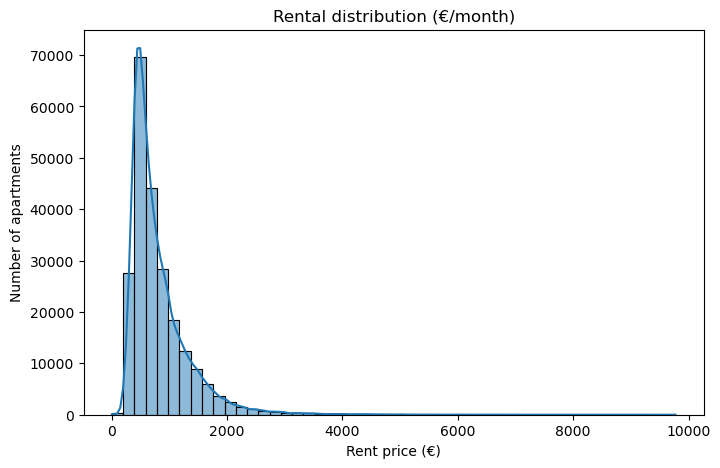

In [30]:
plt.figure(figsize=(8,5))
sns.histplot(df['totalRent'], bins=50, kde=True)
plt.title("Rental distribution (€/month)")
plt.xlabel("Rent price (€)")
plt.ylabel("Number of apartments")
plt.show()

<Axes: >

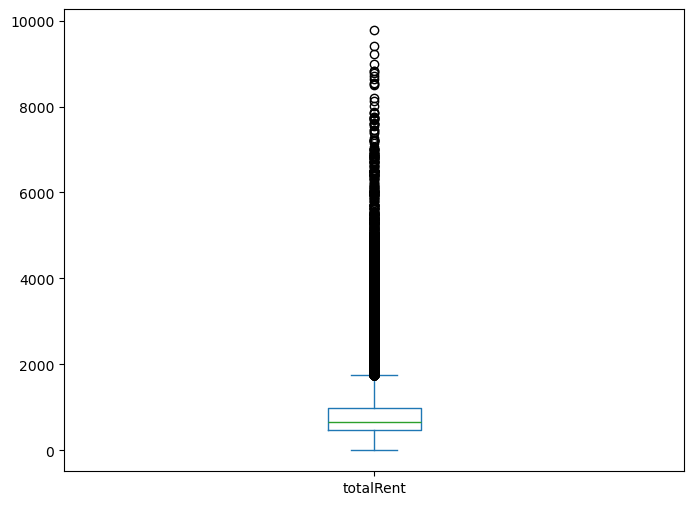

In [31]:
df['totalRent'].plot(kind = 'box', figsize=(8, 6))

In [32]:
df.isnull().sum().sort_values() # check for missing values again

state                     0
borough                   0
city                      0
garden                    0
noRooms                   0
zipcode                   0
lift                      0
street                    0
baseRent                  0
cellar                    0
hasKitchen                0
livingSpace               0
picturecount              0
newlyConst                0
balcony                   0
scoutId                   0
date                      0
totalRent                 0
pricetrend             1607
serviceCharge          4059
description           15946
telekomTvOffer        27375
telekomUploadSpeed    27995
typeOfFlat            30523
heatingType           36770
floor                 40305
facilities            44030
firingTypes           48335
yearConstructed       49195
streetPlain           53856
condition             56803
interiorQual          88703
thermalChar           93564
petsAllowed           95144
dtype: int64

In [33]:
df['petsAllowed'].value_counts()

petsAllowed
negotiable    79315
no            44325
yes            9170
Name: count, dtype: int64

In [34]:
# filling missing values with 'unknown'
df['petsAllowed'] = df['petsAllowed'].fillna('unknown')

In [35]:
df['petsAllowed'].value_counts()

petsAllowed
unknown       95144
negotiable    79315
no            44325
yes            9170
Name: count, dtype: int64

In [36]:
df['thermalChar'].value_counts().sort_values()

thermalChar
160.77      1
84.04       1
92.66       1
135.69      1
210.52      1
         ... 
96.00     735
114.00    744
79.00     757
100.00    788
105.00    815
Name: count, Length: 6946, dtype: int64

In [37]:
# creating new column for thermalChar stating missing or not
df['thermalChar_missing'] = df['thermalChar'].isna().astype(int)

In [38]:
df['thermalChar_missing'].value_counts()

thermalChar_missing
0    134390
1     93564
Name: count, dtype: int64

In [39]:
# filling missing values with median
df['thermalChar'] = df['thermalChar'].fillna(df['thermalChar'].median())

In [40]:
df['thermalChar'].isnull().sum()

0

In [41]:
df['interiorQual'].value_counts()

interiorQual
normal           74136
sophisticated    56848
luxury            6613
simple            1654
Name: count, dtype: int64

In [42]:
# filling missing values with 'unknown'
df['interiorQual'] = df['interiorQual'].fillna('unknown')

In [43]:
df['interiorQual'].isnull().sum()

0

In [44]:
df['condition'].value_counts()

condition
well_kept                             55497
refurbished                           24543
fully_renovated                       22509
mint_condition                        18961
first_time_use                        18134
modernized                            14809
first_time_use_after_refurbishment    13726
negotiable                             1832
need_of_renovation                     1137
ripe_for_demolition                       3
Name: count, dtype: int64

In [45]:
df = df[(df['condition'] != 'ripe_for_demolition') & (df['condition'] != 'negotiable') & (df['condition'] !='need_of_renovation')] # drop this value since it is too narrow

In [46]:
df['condition'].value_counts()

condition
well_kept                             55497
refurbished                           24543
fully_renovated                       22509
mint_condition                        18961
first_time_use                        18134
modernized                            14809
first_time_use_after_refurbishment    13726
Name: count, dtype: int64

In [47]:
# consider condition as important factor, drop na for further analysis
df = df.dropna(subset = ['condition'])
df.shape

(168179, 35)

In [48]:
df['streetPlain'].head()

0                Schüruferstraße
2                      Turnerweg
4    Hermann-Henrich-Meier-Allee
6                     Am_Bahnhof
8                            NaN
Name: streetPlain, dtype: object

In [49]:
df[['street', 'streetPlain']].head()

,street,streetPlain
0,Sch&uuml;ruferstra&szlig;e,Schüruferstraße
2,Turnerweg,Turnerweg
4,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee
6,Am Bahnhof,Am_Bahnhof
8,no_information,NaN


In [50]:
# drop streetPlain which is the same as street but contain missing values
df = df.drop(columns = 'streetPlain')

In [51]:
df['yearConstructed'].value_counts()

yearConstructed
2019.0    8118
1900.0    7237
2018.0    6179
1995.0    3024
1910.0    2965
          ... 
1000.0       1
1755.0       1
1619.0       1
1797.0       1
1678.0       1
Name: count, Length: 411, dtype: int64

In [52]:
# drop yearConstructed which value lower than 1900 and larger than 2022 (unrealistic)
df = df[(df['yearConstructed']>=1900) & (df['yearConstructed']<=2022)]

In [53]:
df['yearConstructed'].isnull().sum()

0

In [54]:
df['firingTypes'].value_counts()

firingTypes
gas                                                                                                                                                                                            57587
district_heating                                                                                                                                                                               29065
oil                                                                                                                                                                                             9859
natural_gas_light                                                                                                                                                                               6120
electricity                                                                                                                                                                                     2492
   

In [55]:
df['firingTypes'].nunique()

107

In [56]:
# filling missing value with unknown
df['firingTypes'] = df['firingTypes'].fillna('unknown')

In [57]:
df['facilities'].value_counts()

facilities
Diese Wohnung wird komplett renoviert und nach Bedarf mit neuen Fußbodenbelägen, Innentüren etc. ausgestattet. Das Bad ist gefliest und wird mit Badewanne bzw. Dusche ausgestattet. \rDiese Wohnung verfügt über eine moderne Ausstattung. Hierzu gehören die Gegensprechanlage, Kabel-, Internet- und Telefonanschluss ebenso, wie der Waschmaschinen- und Geschirrspüleranschluss.\rIndividuelle Ausstattungswünsche werden gern nach Möglichkeit und in Absprache mit unseren Mitarbeitern berücksichtigt. Die Wohnung wird vor Übergabe komplett gereinigt und ist sofort bezugsfertig.\rAbstellmöglichkeiten bietet der mietereigene Keller. Darüber hinaus steht unseren Mietern ein Wäschetrockenplatz zur Verfügung.\rKostenlose öffentliche Parkplätze sind in unmittelbarer Umgebung vorhanden.                                                                                                                                                                                                                   

In [58]:
# filling missing value with unknown
df['facilities'] = df['facilities'].fillna('unknown')

In [59]:
df['floor'].value_counts()

floor
 1.0      32541
 2.0      28918
 3.0      19350
 0.0      13444
 4.0      10327
 5.0       4391
 6.0       1425
 7.0        531
 8.0        315
 9.0        240
 10.0       187
-1.0        149
 11.0       129
 13.0        75
 12.0        69
 14.0        58
 15.0        36
 16.0        18
 17.0        18
 19.0         9
 18.0         6
 20.0         6
 21.0         5
 136.0        3
 24.0         3
 22.0         2
 29.0         1
 105.0        1
 80.0         1
 135.0        1
 31.0         1
 41.0         1
 45.0         1
 32.0         1
 134.0        1
 138.0        1
 124.0        1
 133.0        1
 25.0         1
 83.0         1
 137.0        1
Name: count, dtype: int64

In [60]:
# drop floor which value lower than 0 and more than 50 (unrealistic)
df = df[(df['floor']>=0) & (df['floor']<=50)]

In [61]:
df.isnull().sum().sort_values() # check for missing values again

state                      0
facilities                 0
borough                    0
city                       0
garden                     0
floor                      0
thermalChar                0
noRooms                    0
zipcode                    0
lift                       0
street                     0
petsAllowed                0
interiorQual               0
condition                  0
date                       0
livingSpace                0
cellar                     0
newlyConst                 0
balcony                    0
picturecount               0
baseRent                   0
thermalChar_missing        0
yearConstructed            0
scoutId                    0
firingTypes                0
hasKitchen                 0
totalRent                  0
serviceCharge            841
pricetrend               953
description             4680
heatingType             7847
typeOfFlat             11131
telekomTvOffer         14256
telekomUploadSpeed     14544
dtype: int64

In [62]:
df['heatingType'].value_counts()

heatingType
central_heating                   56673
district_heating                  13616
floor_heating                     10069
gas_heating                        9598
self_contained_central_heating     7220
oil_heating                        2365
heat_pump                          1605
combined_heat_and_power_plant      1391
night_storage_heater                600
wood_pellet_heating                 581
electric_heating                    346
solar_heating                       113
stove_heating                        85
Name: count, dtype: int64

In [63]:
# all options of heatingType which values lower than 2000 and missing value will be grouped to 'other'
counts = df['heatingType'].value_counts()
valid_types = counts[counts >= 2000].index
df['heatingType_new'] = df['heatingType'].where(df['heatingType'].isin(valid_types), 'other')

In [64]:
df['heatingType_new'].value_counts()

heatingType_new
central_heating                   56673
district_heating                  13616
other                             12568
floor_heating                     10069
gas_heating                        9598
self_contained_central_heating     7220
oil_heating                        2365
Name: count, dtype: int64

In [65]:
df['typeOfFlat'].value_counts()

typeOfFlat
apartment              61411
roof_storey            14778
ground_floor           10569
maisonette              4088
other                   3581
raised_ground_floor     2084
penthouse               2025
terraced_flat           1701
half_basement            394
loft                     347
Name: count, dtype: int64

In [66]:
df['typeOfFlat'].isnull().sum()

11131

In [67]:
# filling missing value with 'other', because there is already 'other' value in this column
df['typeOfFlat'] = df['typeOfFlat'].fillna(df['typeOfFlat'].value_counts().idxmax())

In [68]:
df['typeOfFlat'].value_counts()

typeOfFlat
apartment              72542
roof_storey            14778
ground_floor           10569
maisonette              4088
other                   3581
raised_ground_floor     2084
penthouse               2025
terraced_flat           1701
half_basement            394
loft                     347
Name: count, dtype: int64

In [69]:
df[['telekomTvOffer', 'telekomUploadSpeed']].head()

,telekomTvOffer,telekomUploadSpeed
0,ONE_YEAR_FREE,10.0
2,ONE_YEAR_FREE,2.4
4,NaN,NaN
8,ONE_YEAR_FREE,40.0
13,ONE_YEAR_FREE,40.0


In [70]:
df['telekomTvOffer'].value_counts()

telekomTvOffer
ONE_YEAR_FREE    94525
NONE              1856
ON_DEMAND         1472
Name: count, dtype: int64

In [71]:
# filling missing value with unknown
df['telekomTvOffer'] = df['telekomTvOffer'].fillna('unknown')

In [72]:
df['telekomTvOffer'].isnull().sum()

0

In [73]:
df['telekomUploadSpeed'].value_counts()

telekomUploadSpeed
40.0     65675
2.4      17462
10.0     13840
5.0        403
100.0       88
1.0         83
4.0         14
Name: count, dtype: int64

In [74]:
# filling missing value with most frequency
df['telekomUploadSpeed'] = df['telekomUploadSpeed'].fillna(df['telekomUploadSpeed'].mode()[0])

In [75]:
df['telekomUploadSpeed'].isnull().sum()

0

In [76]:
df['description'].isnull().sum()

4680

In [77]:
# creating new column stating missing value and then drop description column
df['description_missing'] = df['description'].isna().astype(int)
df = df.drop(columns = 'description')

In [78]:
df['serviceCharge'].value_counts().sort_values()

serviceCharge
317.72       1
271.75       1
285.20       1
217.40       1
94.84        1
          ... 
130.00    3302
120.00    4502
200.00    5074
100.00    5164
150.00    6209
Name: count, Length: 7337, dtype: int64

In [79]:
# filling missing value with mean
df['serviceCharge'] =df['serviceCharge'].fillna(df['serviceCharge'].mean())

In [80]:
df['pricetrend'].value_counts().sort_values()

pricetrend
 8.48       1
-1.51       1
 8.09       1
-0.92       1
 9.48       1
         ... 
 1.92     725
 3.23     796
 3.85     804
 3.33     960
 0.00    4745
Name: count, Length: 1144, dtype: int64

In [81]:
# filling missing value with mean
df['pricetrend'] = df['pricetrend'].fillna(df['pricetrend'].mean())

In [82]:
df.isnull().sum()

state                     0
serviceCharge             0
heatingType            7847
telekomTvOffer            0
newlyConst                0
balcony                   0
picturecount              0
pricetrend                0
telekomUploadSpeed        0
totalRent                 0
yearConstructed           0
scoutId                   0
firingTypes               0
hasKitchen                0
cellar                    0
baseRent                  0
livingSpace               0
condition                 0
interiorQual              0
petsAllowed               0
street                    0
lift                      0
typeOfFlat                0
zipcode                   0
noRooms                   0
thermalChar               0
floor                     0
garden                    0
city                      0
borough                   0
facilities                0
date                      0
thermalChar_missing       0
heatingType_new           0
description_missing       0
dtype: int64

In [83]:
df['picturecount'].value_counts()

picturecount
9     9000
8     8789
10    8773
7     8267
11    7599
      ... 
75       1
67       1
70       1
83       1
69       1
Name: count, Length: 85, dtype: int64

In [84]:
df['garden'].value_counts()

garden
False    88112
True     23997
Name: count, dtype: int64

In [85]:
df['noRooms'].value_counts()

noRooms
3.00      39726
2.00      36928
4.00      11994
1.00      10608
2.50       3851
3.50       3692
5.00       2311
1.50       1338
4.50        826
6.00        462
5.50        133
7.00        107
8.00         48
6.50         26
2.20         19
7.50          6
9.00          5
11.00         4
10.00         4
13.00         2
8.50          2
12.00         2
1.10          2
2.30          1
23.00         1
2.70          1
100.00        1
3.10          1
2.90          1
2.10          1
230.00        1
21.00         1
3.40          1
15.00         1
45.00         1
1.25          1
Name: count, dtype: int64

In [86]:
# drop value which is smaller than 1 or larger than 12 (unrealistic)
# round other values to 0.5 (might be typing error)
df['noRooms'] = df['noRooms'].apply(lambda x: round(x * 2) / 2)
df = df[(df['noRooms']>=1) & (df['noRooms']<=12)]

In [87]:
df['noRooms'].value_counts()

noRooms
3.0     39728
2.0     36948
4.0     11994
1.0     10611
2.5      3853
3.5      3693
5.0      2311
1.5      1338
4.5       826
6.0       462
5.5       133
7.0       107
8.0        48
6.5        26
7.5         6
9.0         5
10.0        4
11.0        4
12.0        2
8.5         2
Name: count, dtype: int64

In [88]:
df['lift'].value_counts()

lift
False    79795
True     32306
Name: count, dtype: int64

In [89]:
df['cellar'].value_counts()

cellar
True     80616
False    31485
Name: count, dtype: int64

In [90]:
df['hasKitchen'].value_counts()

hasKitchen
False    70561
True     41540
Name: count, dtype: int64

In [91]:
df['newlyConst'].value_counts()

newlyConst
False    99845
True     12256
Name: count, dtype: int64

In [92]:
df['balcony'].value_counts()

balcony
True     76634
False    35467
Name: count, dtype: int64

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112101 entries, 0 to 268847
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   state                112101 non-null  object 
 1   serviceCharge        112101 non-null  float64
 2   heatingType          104254 non-null  object 
 3   telekomTvOffer       112101 non-null  object 
 4   newlyConst           112101 non-null  bool   
 5   balcony              112101 non-null  bool   
 6   picturecount         112101 non-null  int64  
 7   pricetrend           112101 non-null  float64
 8   telekomUploadSpeed   112101 non-null  float64
 9   totalRent            112101 non-null  float64
 10  yearConstructed      112101 non-null  float64
 11  scoutId              112101 non-null  int64  
 12  firingTypes          112101 non-null  object 
 13  hasKitchen           112101 non-null  bool   
 14  cellar               112101 non-null  bool   
 15  baseRent             1

### Casting

In [94]:
df['state'] = df.state.astype('category')
df['city'] = df.city.astype('category')
df['borough'] = df.borough.astype('category')
df['zipcode'] = df.zipcode.astype('category')
df['typeOfFlat'] = df.typeOfFlat.astype('category')
df['condition'] = df.condition.astype('category')
df['heatingType_new'] = df.heatingType.astype('category')
df['telekomTvOffer'] = df.telekomTvOffer.astype('category')
df['firingTypes'] = df.firingTypes.astype('category')

## Data analysis

In [95]:
df1 = df.copy()

In [96]:
# calculate rent per square meter
df1['price_per_sqm'] = df1['totalRent']/df1['livingSpace']

In [97]:
df1['price_per_sqm'].value_counts()

price_per_sqm
10.000000    824
7.500000     431
8.000000     419
12.500000    345
7.000000     336
            ... 
7.556382       1
8.412418       1
8.373541       1
20.345455      1
16.500948      1
Name: count, Length: 61603, dtype: int64

<Axes: ylabel='Frequency'>

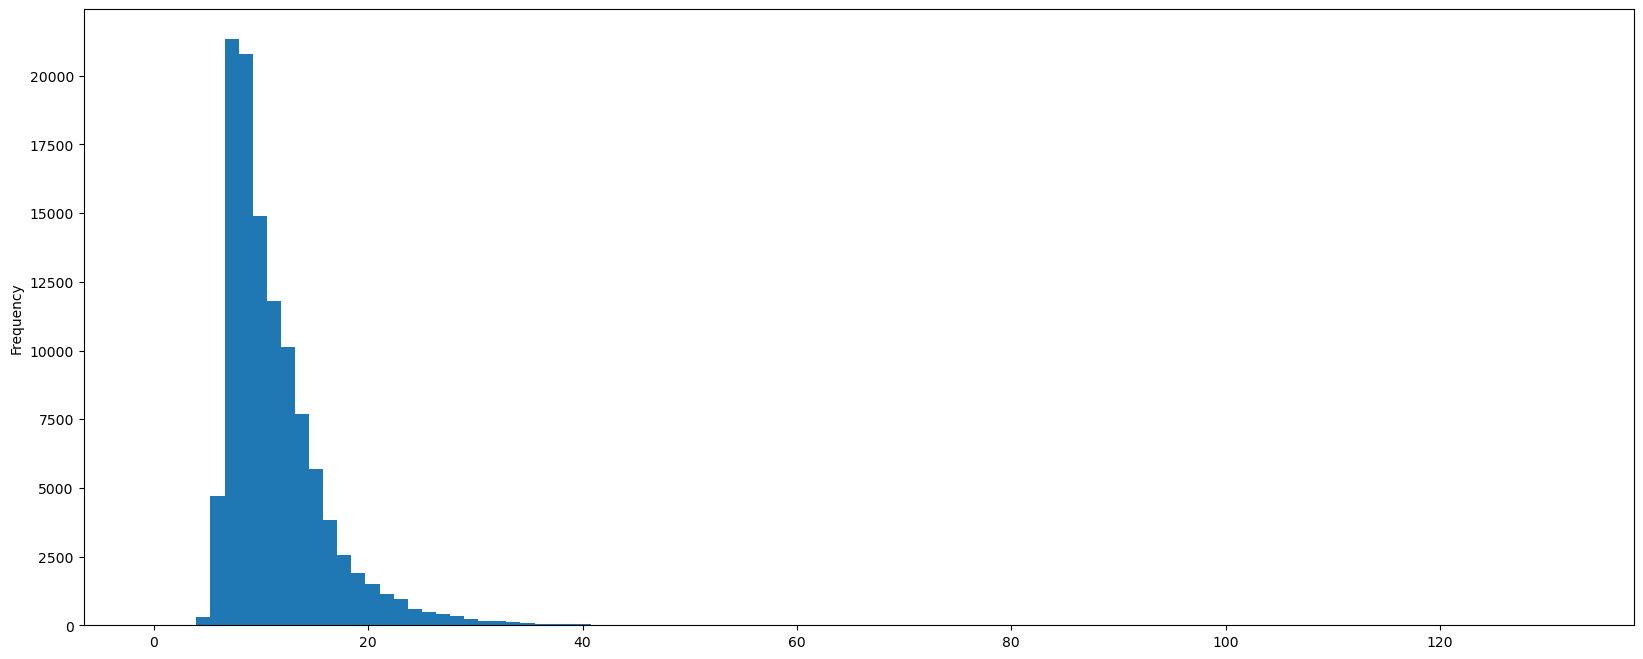

In [98]:
plt.figure(figsize = (20,8))
df1['price_per_sqm'].plot(kind = 'hist', bins = 100)

<Axes: xlabel='livingSpace', ylabel='price_per_sqm'>

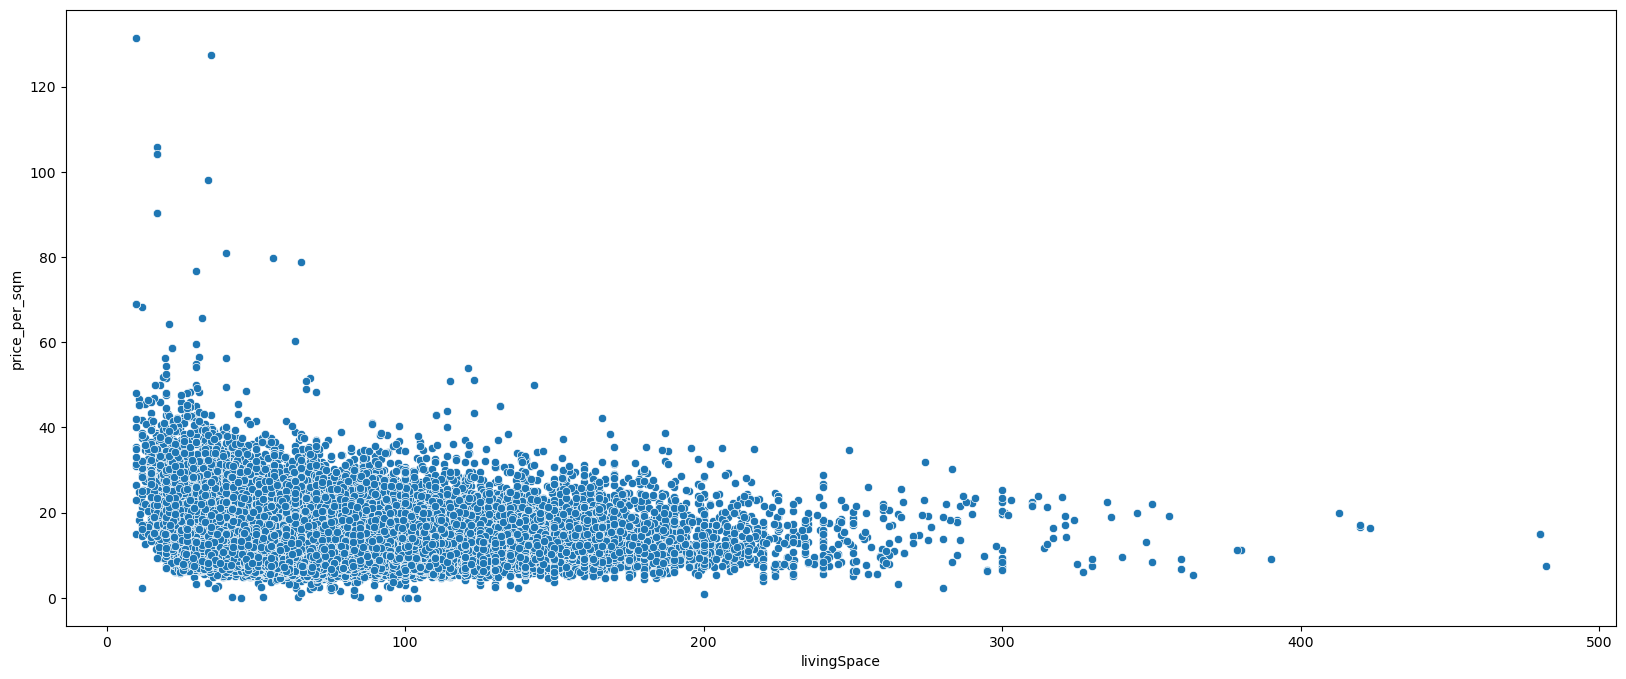

In [99]:
plt.figure(figsize = (20,8))
sns.scatterplot(data = df1, x ='livingSpace', y = 'price_per_sqm')

In [100]:
# dropping outliders using quantile method
Q1 = df1['price_per_sqm'].quantile(0.25)
Q3 = df1['price_per_sqm'].quantile(0.75)
IQR = Q3 - Q1

# dropping outlier
df1_clean= df1[(df1['price_per_sqm'] >= Q1 - 1.5 * IQR) &
              (df1['price_per_sqm'] <= Q3 + 1.5 * IQR)]

<Axes: ylabel='Frequency'>

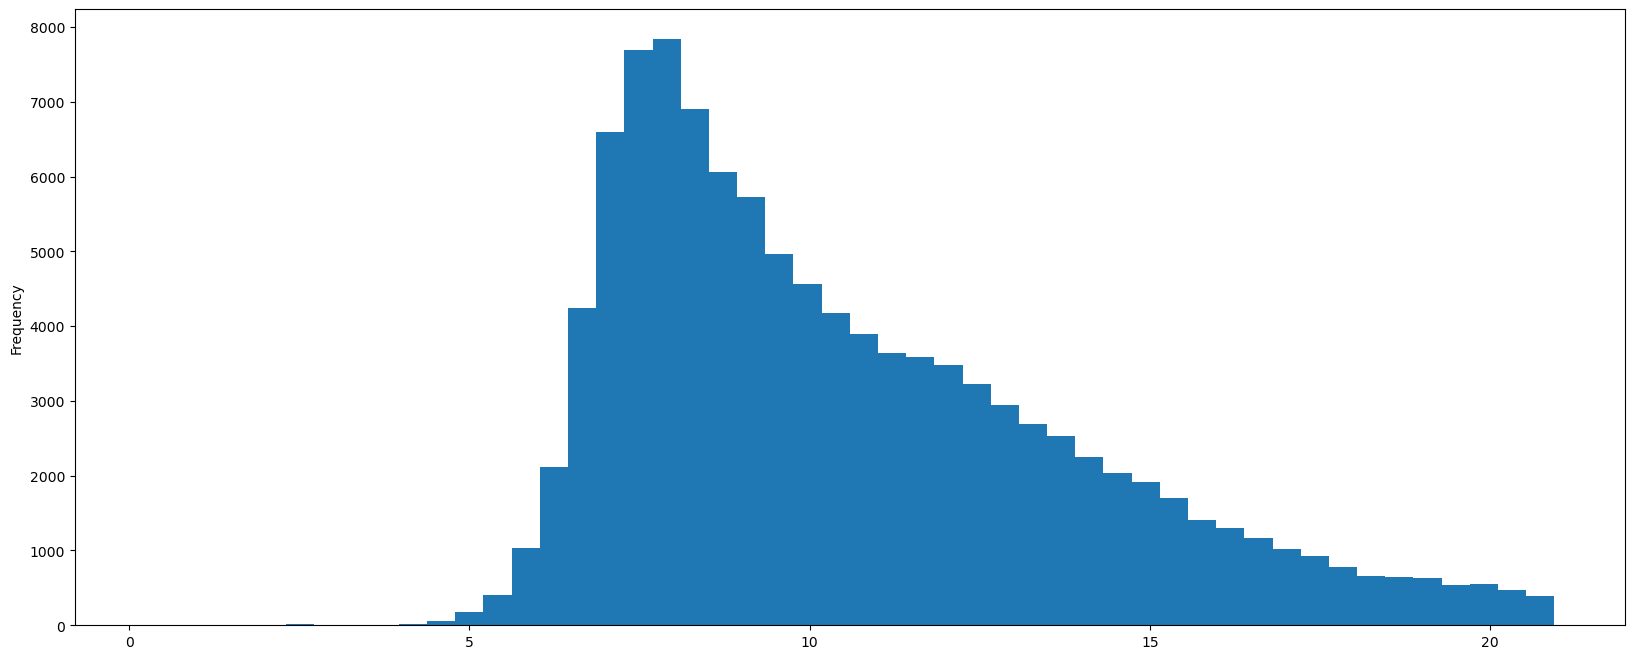

In [101]:
plt.figure(figsize = (20,8))
df1_clean['price_per_sqm'].plot(kind = 'hist', bins = 50)

<Axes: xlabel='livingSpace', ylabel='price_per_sqm'>

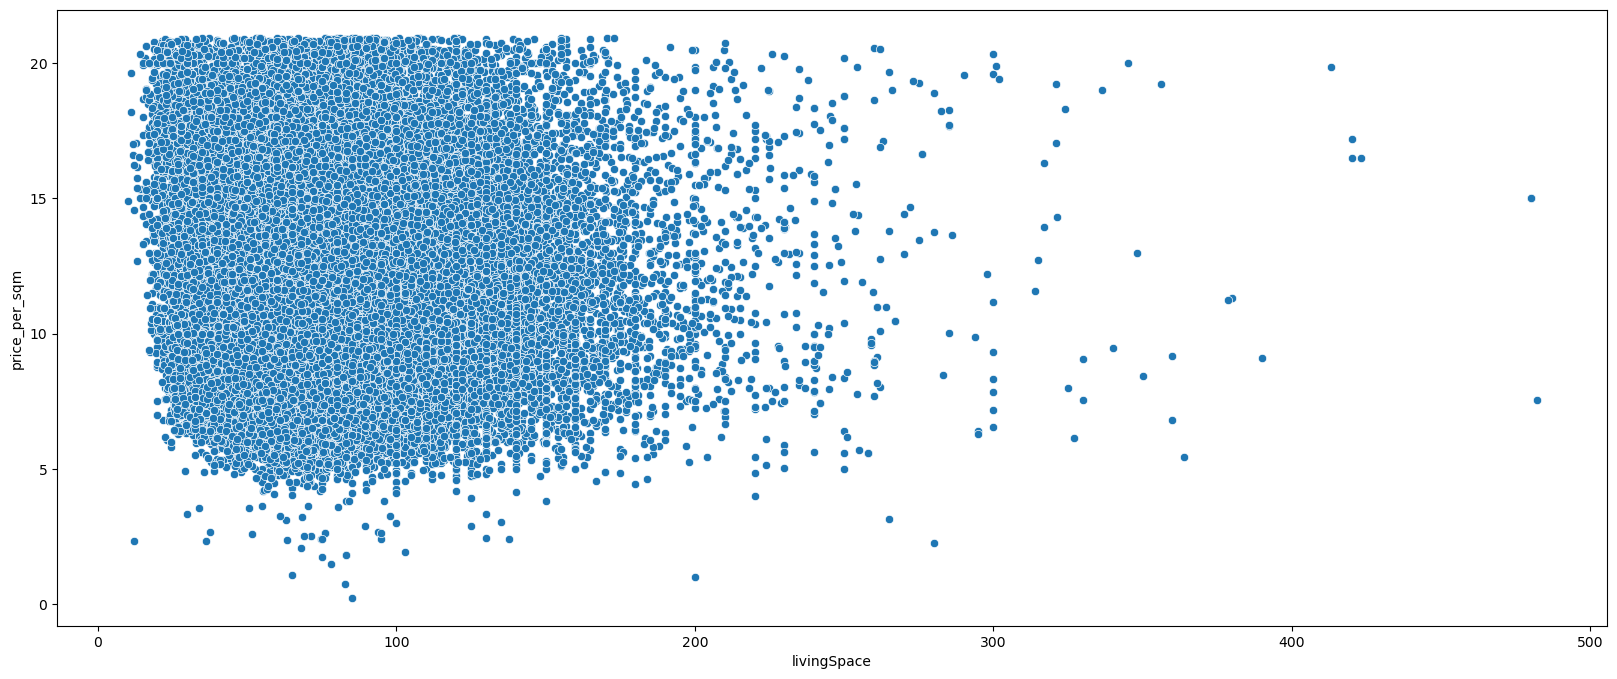

In [102]:
plt.figure(figsize = (20,8))
sns.scatterplot(data = df1_clean, x ='livingSpace', y = 'price_per_sqm')

In [103]:
df1_clean['price_per_sqm'].describe()

count    107041.000000
mean         10.580110
std           3.354261
min           0.235294
25%           7.913111
50%           9.726027
75%          12.631579
max          20.942857
Name: price_per_sqm, dtype: float64

### Rental price below 3 is unusual and needs clarification

In [104]:
df1_outliers = df1_clean[df1_clean['price_per_sqm'] < 3]

print(df1_outliers['price_per_sqm'].describe())

# check some rows
print(df1_outliers[['price_per_sqm', 'totalRent', 'livingSpace', 'typeOfFlat', 'heatingType', 'heatingType_new', 'yearConstructed', 'condition']].head(20))

# count outlier
print("No. outlier (<3):", df1_outliers.shape[0])
print("Outlier ratio:", df1_outliers.shape[0] / df.shape[0] * 100, "%")

count    29.000000
mean      2.134529
std       0.662868
min       0.235294
25%       1.807229
50%       2.400000
75%       2.606178
max       2.904055
Name: price_per_sqm, dtype: float64
        price_per_sqm  totalRent  livingSpace     typeOfFlat  \
5885         1.733333     130.00        75.00      apartment   
7673         1.000000     200.00       200.00      apartment   
19267        2.880000     360.00       125.00      apartment   
21992        2.525961     180.00        71.26   ground_floor   
33492        2.659574     250.00        94.00      apartment   
44138        2.410284     180.00        74.68      apartment   
51128        2.058824     140.00        68.00      apartment   
51951        2.507246     173.00        69.00      apartment   
54301        2.669514     100.00        37.46      apartment   
59840        1.474359     115.00        78.00      apartment   
61951        1.807229     150.00        83.00      apartment   
70256        2.337734      85.00        36.3

### based on the data above, it looks like there is an error in typing input. Therefore, drop 'price_per_sqm' below 3

In [105]:
df1_clean = df1_clean[df1_clean['price_per_sqm'] >3]

In [106]:
df1_clean.shape

(107011, 36)

<Axes: ylabel='Frequency'>

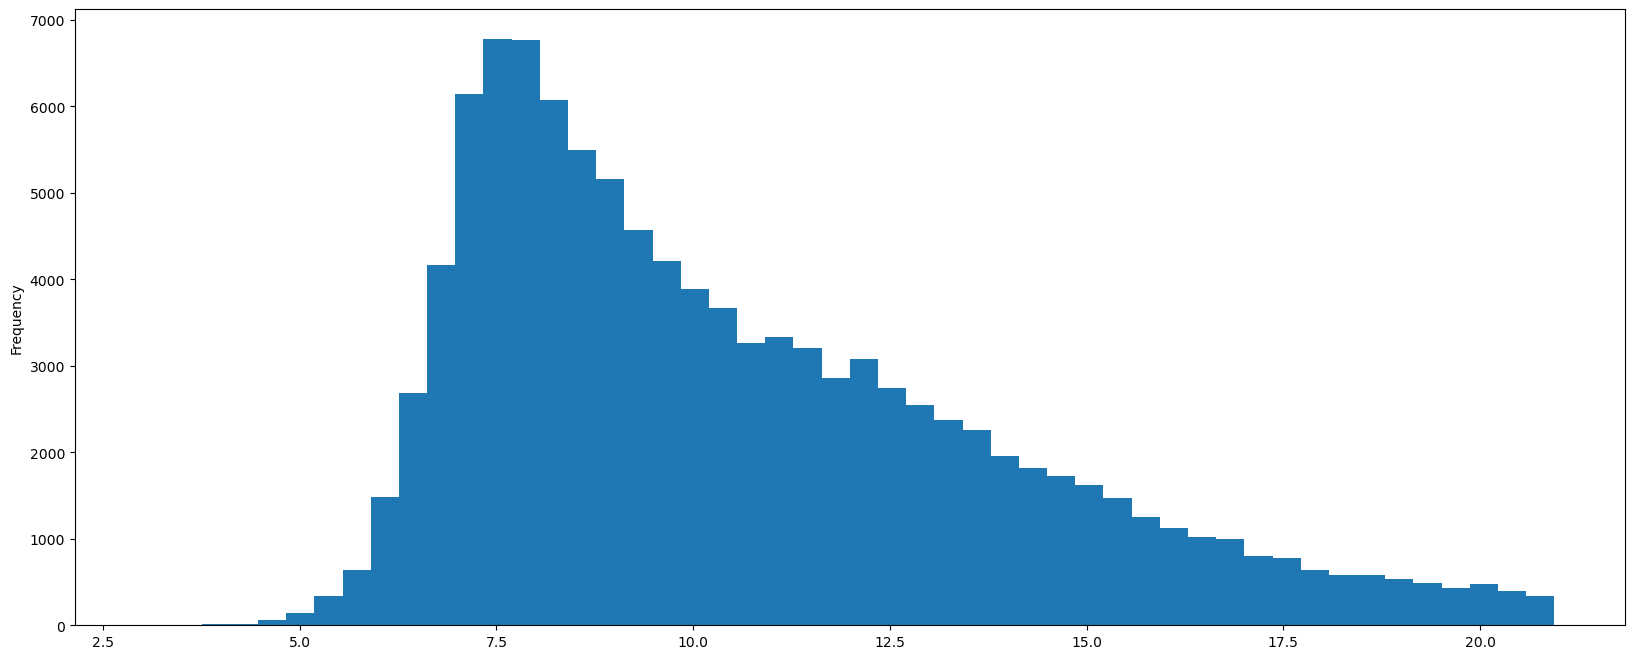

In [107]:
plt.figure(figsize = (20,8))
df1_clean['price_per_sqm'].plot(kind = 'hist', bins = 50)

In [108]:
df1_clean['price_per_sqm'].describe()

count    107011.000000
mean         10.582469
std           3.351750
min           3.037037
25%           7.914378
50%           9.727273
75%          12.631579
max          20.942857
Name: price_per_sqm, dtype: float64

In [109]:
df2 = df1_clean

In [110]:
df2.date.value_counts()

date
Feb20    31222
May19    30528
Oct19    26668
Sep18    18593
Name: count, dtype: int64

In [111]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107011 entries, 0 to 268847
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   state                107011 non-null  category
 1   serviceCharge        107011 non-null  float64 
 2   heatingType          99644 non-null   object  
 3   telekomTvOffer       107011 non-null  category
 4   newlyConst           107011 non-null  bool    
 5   balcony              107011 non-null  bool    
 6   picturecount         107011 non-null  int64   
 7   pricetrend           107011 non-null  float64 
 8   telekomUploadSpeed   107011 non-null  float64 
 9   totalRent            107011 non-null  float64 
 10  yearConstructed      107011 non-null  float64 
 11  scoutId              107011 non-null  int64   
 12  firingTypes          107011 non-null  category
 13  hasKitchen           107011 non-null  bool    
 14  cellar               107011 non-null  bool    
 15  baseR

In [112]:
df2.to_csv('housing_clean_data.csv')

### Which state has the highest and lowest rental price per square meter?

In [113]:
price_state = df2.groupby('state')['price_per_sqm'].mean().sort_values(ascending = False).reset_index()

C:\Users\ldanh\AppData\Local\Temp\ipykernel_24612\1490038976.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_state = df2.groupby('state')['price_per_sqm'].mean().sort_values(ascending = False).reset_index()


In [114]:
price_state

,state,price_per_sqm
0,Hamburg,15.670039
1,Berlin,14.881978
2,Hessen,13.624751
3,Bayern,13.155423
4,Baden_Württemberg,13.117926
5,Bremen,11.676796
6,Schleswig_Holstein,11.520264
7,Rheinland_Pfalz,10.688244
8,Nordrhein_Westfalen,10.553794
9,Niedersachsen,10.336103


[Text(-40, 0, '8.161'),
 Text(-40, 0, '8.162'),
 Text(-40, 0, '8.592'),
 Text(-40, 0, '8.892'),
 Text(-40, 0, '9.742'),
 Text(-40, 0, '9.841'),
 Text(-40, 0, '10.336'),
 Text(-40, 0, '10.554'),
 Text(-40, 0, '10.688'),
 Text(-40, 0, '11.520'),
 Text(-40, 0, '11.677'),
 Text(-40, 0, '13.118'),
 Text(-40, 0, '13.155'),
 Text(-40, 0, '13.625'),
 Text(-40, 0, '14.882'),
 Text(-40, 0, '15.670')]

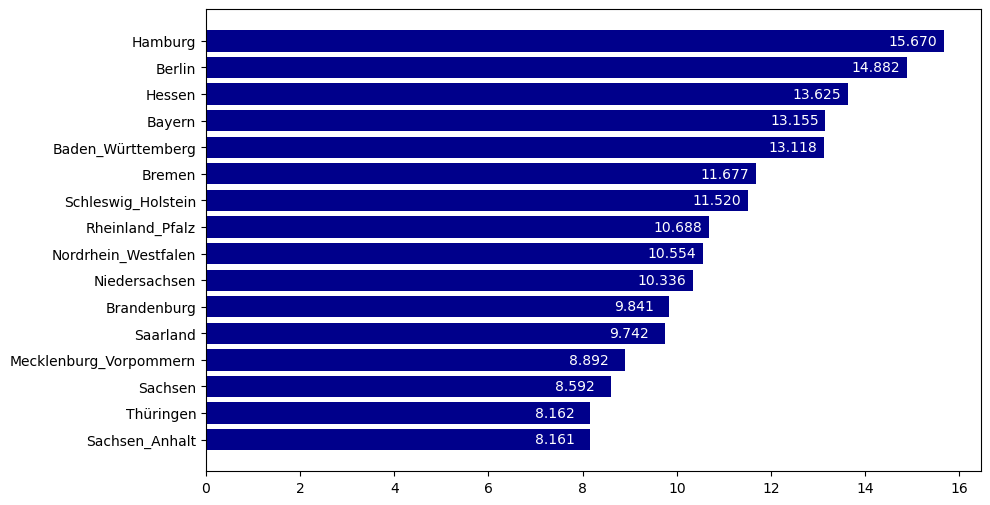

In [115]:
fig, ax = plt.subplots(figsize = (10,6))
price_state = price_state.sort_values(by = 'price_per_sqm')
label = list(price_state.state)

ax1 = ax.barh(label, price_state['price_per_sqm'], label = label, color = 'darkblue')
ax.bar_label(ax1, fmt='%.3f', padding= -40, color = 'white')

! pip install pandas-profiling
! pip install autoviz

In [116]:
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [117]:
%matplotlib inline

dft = AV.AutoViz(
    filename='',
    depVar='totalRent',
    dfte=df1,
    lowess=False,
    chart_format='svg'
)

### Top 10 cities with highest average rental price per sqm

In [118]:
top10_cities_h = df2.groupby('city')['price_per_sqm'].mean().sort_values(ascending = False).reset_index().head(10)
top10_cities_h

,city,price_per_sqm
0,München,18.682649
1,München_Kreis,17.537579
2,Frankfurt_am_Main,17.043351
3,Stuttgart,16.588232
4,Starnberg_Kreis,16.334869
5,Ebersberg_Kreis,16.219573
6,Fürstenfeldbruck_Kreis,16.176320
7,Freiburg_im_Breisgau,16.073464
8,Heidelberg,15.934361
9,Hamburg,15.670039


[Text(-40, 0, '15.670'),
 Text(-40, 0, '15.934'),
 Text(-40, 0, '16.073'),
 Text(-40, 0, '16.176'),
 Text(-40, 0, '16.220'),
 Text(-40, 0, '16.335'),
 Text(-40, 0, '16.588'),
 Text(-40, 0, '17.043'),
 Text(-40, 0, '17.538'),
 Text(-40, 0, '18.683')]

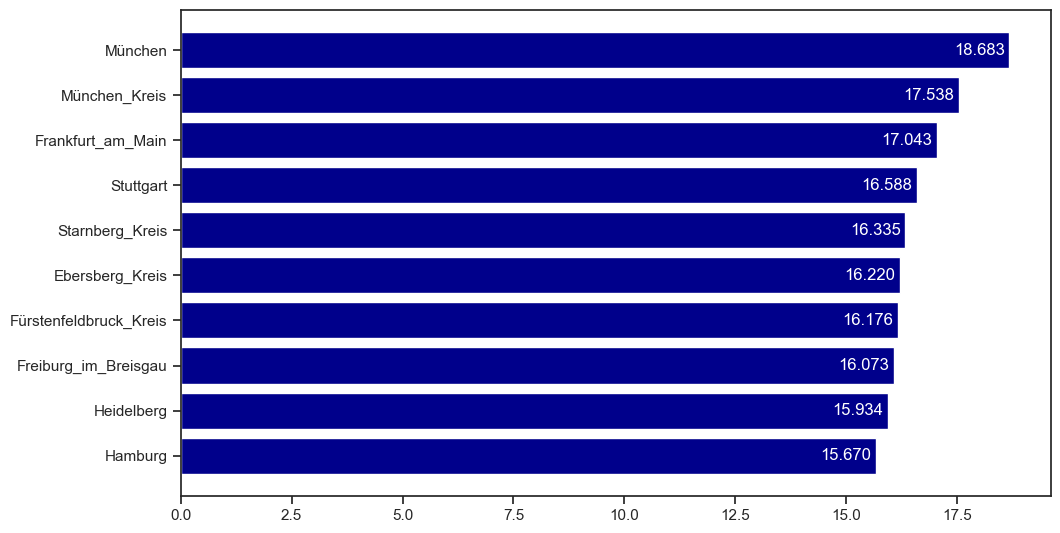

In [119]:
fig, ax = plt.subplots(figsize = (10,6))
top10_cities_h = top10_cities_h.sort_values(by = 'price_per_sqm', ascending = True)
label = list(top10_cities_h.city)

ax1 = ax.barh(label, top10_cities_h['price_per_sqm'], label = label, color = 'darkblue')
ax.bar_label(ax1, fmt='%.3f', padding= -40, color = 'white')

### Top 10 cities with lowest average rental price per sqm

In [120]:
top10_cities_l = df2.groupby('city')['price_per_sqm'].mean().sort_values().reset_index().head(10)
top10_cities_l

,city,price_per_sqm
0,Lüchow_Dannenberg_Kreis,6.147140
1,Plauen,6.843140
2,Vogtlandkreis,6.866006
3,Uecker_Randow_Kreis,6.967417
4,Görlitz_Kreis,7.010109
5,Kronach_Kreis,7.013391
6,Greiz_Kreis,7.023061
7,Wunsiedel_im_Fichtelgebirge_Kreis,7.026533
8,Görlitz,7.043809
9,Stendal_Kreis,7.088111


[Text(-40, 0, '7.088'),
 Text(-40, 0, '7.044'),
 Text(-40, 0, '7.027'),
 Text(-40, 0, '7.023'),
 Text(-40, 0, '7.013'),
 Text(-40, 0, '7.010'),
 Text(-40, 0, '6.967'),
 Text(-40, 0, '6.866'),
 Text(-40, 0, '6.843'),
 Text(-40, 0, '6.147')]

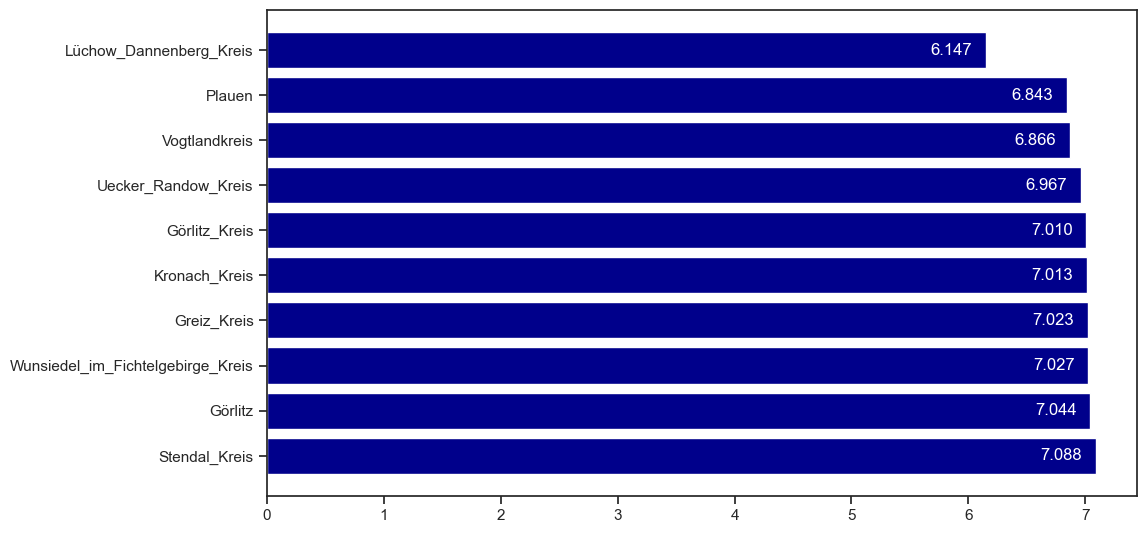

In [121]:
fig, ax = plt.subplots(figsize = (10,6))
top10_cities_l = top10_cities_l.sort_values(by = 'price_per_sqm', ascending = False)
label = list(top10_cities_l.city)

ax1 = ax.barh(label, top10_cities_l['price_per_sqm'], label = label, color = 'darkblue')
ax.bar_label(ax1, fmt='%.3f', padding= -40, color = 'white')

### Independent sample T-test for boolean variables

In [122]:
group_garden = df2.groupby('garden')['price_per_sqm'].mean()

In [123]:
group_garden

garden
False    10.644625
True     10.354363
Name: price_per_sqm, dtype: float64

In [124]:
group_lift = df2.groupby('lift')['price_per_sqm'].mean()
group_lift

lift
False     9.767349
True     12.796586
Name: price_per_sqm, dtype: float64

In [125]:
group_cellar = df2.groupby('cellar')['price_per_sqm'].mean()
group_cellar

cellar
False    10.551666
True     10.594270
Name: price_per_sqm, dtype: float64

In [126]:
kitchen_group = df2.groupby('hasKitchen')['price_per_sqm'].mean()
kitchen_group

hasKitchen
False     9.650824
True     12.326015
Name: price_per_sqm, dtype: float64

In [127]:
group_newlyConst = df2.groupby('newlyConst')['price_per_sqm'].mean()
group_newlyConst

newlyConst
False    10.202197
True     14.007799
Name: price_per_sqm, dtype: float64

In [128]:
group_balcony = df2.groupby('balcony')['price_per_sqm'].mean()
group_balcony

balcony
False     9.544240
True     11.068879
Name: price_per_sqm, dtype: float64

In [129]:
from scipy import stats


In [130]:
bool_vars = ['hasKitchen', 'garden', 'lift', 'cellar', 'newlyConst', 'balcony']

results = []

for col in bool_vars:
    group_true = df2[df2[col] == True]['price_per_sqm']
    group_false = df2[df2[col] == False]['price_per_sqm']
    
    # Independent T-test
    t_stat, p_val = stats.ttest_ind(group_true, group_false, nan_policy='omit')
    
    results.append({
        'Variable': col,
        'Mean_True': group_true.mean(),
        'Mean_False': group_false.mean(),
        'T-stat': t_stat,
        'P-value': p_val
    })

results_df = pd.DataFrame(results)
print(results_df)

    Variable   Mean_True  Mean_False    T-stat       P-value  
0  hasKitchen  12.326015    9.650824  134.491813  0.000000e+00
1      garden  10.354363   10.644625  -11.628546  3.081439e-31
2        lift  12.796586    9.767349  143.113458  0.000000e+00
3      cellar  10.594270   10.551666    1.860818  6.277258e-02
4  newlyConst  14.007799   10.202197  118.467626  0.000000e+00
5     balcony  11.068879    9.544240   70.970151  0.000000e+00


In [131]:
import statsmodels.api as sm

In [132]:
X = df2[['hasKitchen', 'garden', 'lift', 'cellar', 'newlyConst', 'balcony']].astype(int)
y = df2['price_per_sqm']

X = sm.add_constant(X)  # thêm hằng số
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          price_per_sqm   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     8650.
Date:                Wed, 03 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:13:31   Log-Likelihood:            -2.6011e+05
No. Observations:              107011   AIC:                         5.202e+05
Df Residuals:                  107004   BIC:                         5.203e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6778      0.020    427.453      0.0

In [133]:
lr = LinearRegression()
lr.fit(X, y)
print("Intercept:", lr.intercept_)
print("Coefficients:")
for col, coef in zip(X.columns, lr.coef_):
    print(f"{col}: {coef:.4f}")

Intercept: 8.677803144597883
Coefficients:
const: 0.0000
hasKitchen: 2.3454
garden: -0.2107
lift: 1.9717
cellar: -0.1408
newlyConst: 2.4470
balcony: 0.6752


In [134]:
lr.score(X,y)

0.3266040512881664

## Fit Model with only boolean variables

In [135]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

Text(0.5, 1.0, 'R^2 Using Test Data')

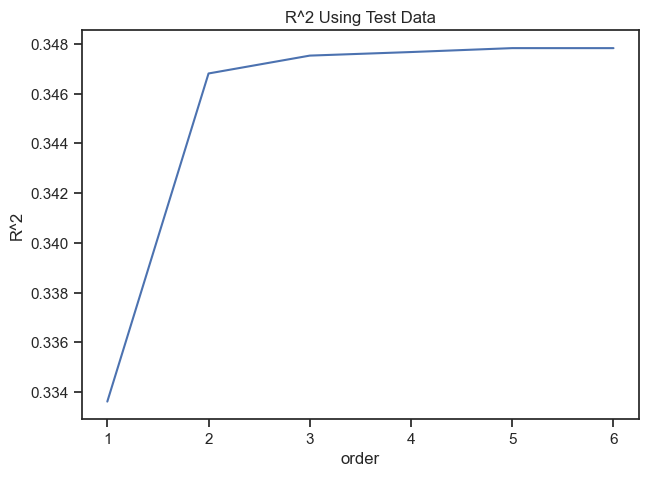

In [136]:
Rsq_test = []
order = [1,2,3,4,5,6]
for n in order:
    pr = PolynomialFeatures(degree = n)
    x_train_pr = pr.fit_transform(x_train)
    x_test_pr = pr.fit_transform(x_test)
    lr.fit(x_train_pr, y_train)
    Rsq_test.append(lr.score(x_test_pr, y_test))
plt.plot(order, Rsq_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')

In [137]:
print(Rsq_test)

[0.33362265096957255, 0.34681006165092076, 0.3475281788161029, 0.34767161858366025, 0.34782905707062706, 0.3478284133790811]


### R_square increases significantly from 1 to 2, and then remain steady when increasing the order of Polynomial degree. Choose order = 2.

In [138]:
pr2 = PolynomialFeatures(degree = 2)
x_train_pr2 = pr2.fit_transform(x_train)
x_test_pr2 = pr2.fit_transform(x_test)

In [139]:
RR = Ridge()
para = [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 1000000]}]
Grid = GridSearchCV(RR, para,cv=4)

In [140]:
Grid.fit(x_train_pr2, y_train)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    1000000]}])

In [141]:
bestRR = Grid.best_estimator_
bestRR

Ridge(alpha=10)

In [142]:
bestRR.score(x_test_pr2, y_test)

0.3467665276128621

### Rewrite the code with StandardScaler and Pipeline

In [143]:
pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ridge', Ridge())
])

# parameters
param_grid = {
    'poly__degree': [2],                # degree = 2 or 3
    'ridge__alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000]  # alpha in Ridge
}

# GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=4, scoring='r2')
grid.fit(x_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best R^2:", grid.best_score_)

# Evaluating based on test set
test_score = grid.score(x_test, y_test)
print("Test R^2:", test_score)

Best parameters: {'poly__degree': 2, 'ridge__alpha': 100}
Best R^2: 0.33385563173881744
Test R^2: 0.34680049007786495


### Best model achieved with PolynomialFeatures (degree = 2) and Ridge (alpha = 1), when data is splited to 4 folds.

## Fit model with all possible variables

In [144]:
bool_vars = ['hasKitchen', 'garden', 'lift', 'cellar', 'newlyConst', 'balcony']
cate_vars = ['state', 'typeOfFlat', 'heatingType_new', 'condition']
cont_vars = ['noRooms', 'floor', 'yearConstructed']

In [145]:
target = 'price_per_sqm'

### Fit model with each group of variables

In [146]:
def run_regression(features, name):

    X = df2[features]
    y = df2[target]

    # handle categorical
    transformers = []
    if any(f in cate_vars for f in features):
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), [f for f in features if f in cate_vars]))
    
    if transformers:
        preprocessor = ColumnTransformer(transformers=transformers, remainder="passthrough")
    else:
        preprocessor = "passthrough"
    
    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression())
    ])
    
    model.fit(X, y)
    y_pred = model.predict(X)
    
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    print(f"--- {name} ---")
    print(f"R²: {r2:.4f}, MSE: {mse:.4f}")
    print()

# running for each group
run_regression(bool_vars, "Boolean vars")
run_regression(cate_vars, "Categorical vars")
run_regression(cont_vars, "Continuous vars")

--- Boolean vars ---
R²: 0.3266, MSE: 7.5650

--- Categorical vars ---
R²: 0.5023, MSE: 5.5911

--- Continuous vars ---
R²: 0.1091, MSE: 10.0087



### Fit model with bool_vars and cate_vars

In [147]:
X = df2[bool_vars + cate_vars]
y = df2['price_per_sqm']

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[("cat", OneHotEncoder(drop="first"), cate_vars),("bool", "passthrough", bool_vars)])

# Pipeline creation
pipe = Pipeline(steps=[("preprocess", preprocessor),("ridge", Ridge())])

# GridSearchCV
param_grid = {"ridge__alpha": [0.001, 0.1, 1, 10, 100, 1000, 10000]}
grid = GridSearchCV(pipe, param_grid, cv=4, scoring="r2", n_jobs=-1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit
grid.fit(X_train, y_train)

# 6. Result
print("Best alpha:", grid.best_params_)
print("Best R² (CV):", grid.best_score_)

# Evaluating on test sample
y_hat = grid.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
print(f"Test MSE: {mse:.2f}")

Best alpha: {'ridge__alpha': 1}
Best R² (CV): 0.5614350515572357
Test MSE: 4.96


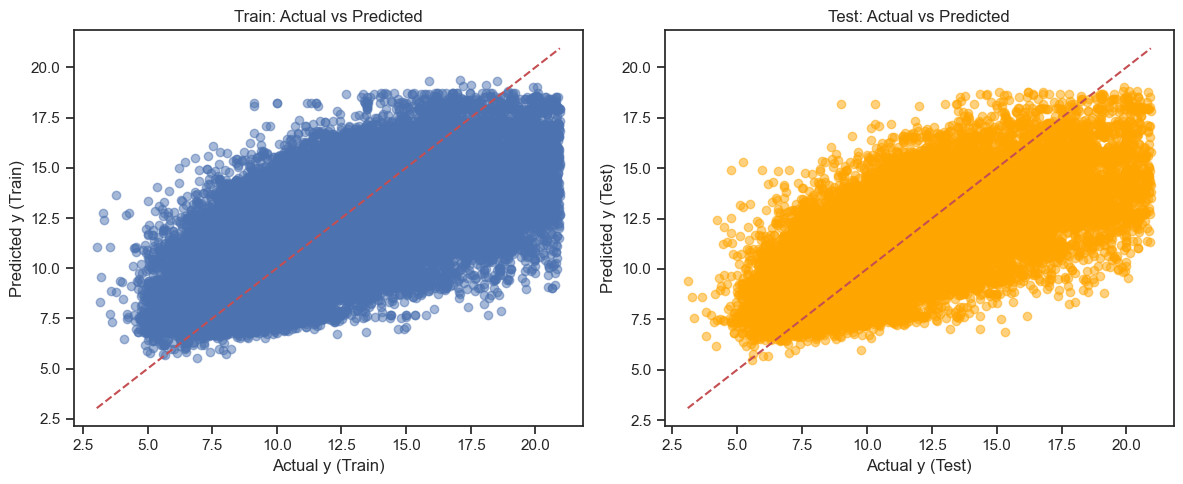

In [148]:
y_train_hat = grid.predict(X_train)
y_test_hat = grid.predict(X_test)

plt.figure(figsize=(12,5))

# Train
plt.subplot(1,2,1)
plt.scatter(y_train, y_train_hat, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # line y=x
plt.xlabel("Actual y (Train)")
plt.ylabel("Predicted y (Train)")
plt.title("Train: Actual vs Predicted")

# Test
plt.subplot(1,2,2)
plt.scatter(y_test, y_test_hat, alpha=0.5, color="orange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual y (Test)")
plt.ylabel("Predicted y (Test)")
plt.title("Test: Actual vs Predicted")

plt.tight_layout()
plt.show()

### fit model with bool_vars + cate_vars + cont_vars

In [149]:
bool_vars = ['hasKitchen', 'garden', 'lift', 'cellar', 'newlyConst', 'balcony']
cate_vars = ['state', 'typeOfFlat', 'heatingType_new', 'condition']
cont_vars = ['noRooms', 'floor','yearConstructed']

In [150]:
X = df2[bool_vars + cate_vars + cont_vars]
y = df2['price_per_sqm']

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), cont_vars),
        ("cat", OneHotEncoder(drop="first"), cate_vars),
        ("bool", "passthrough", bool_vars)  # bool keep 0/1
    ])

# Pipeline creation
pipe = Pipeline(steps=[("preprocess", preprocessor),("ridge", Ridge())])

# GridSearchCV
param_grid = {"ridge__alpha": [0.001, 0.1, 1, 10, 100, 1000, 10000]}
grid = GridSearchCV(pipe, param_grid, cv=4, scoring="r2", n_jobs=-1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit
grid.fit(X_train, y_train)

# 6. Result
print("Best alpha:", grid.best_params_)
print("Best R² (CV):", grid.best_score_)

# Evaluating on test sample
y_hat = grid.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
print(f"Test MSE: {mse:.2f}")

Best alpha: {'ridge__alpha': 1}
Best R² (CV): 0.5731851098042078
Test MSE: 4.82


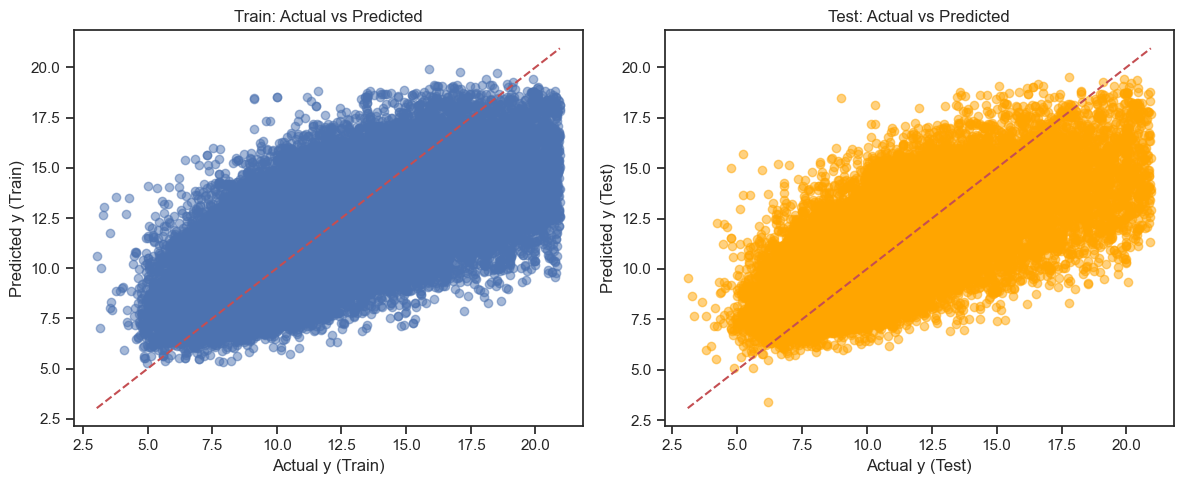

In [151]:
y_train_hat = grid.predict(X_train)
y_test_hat = grid.predict(X_test)

plt.figure(figsize=(12,5))

# Train
plt.subplot(1,2,1)
plt.scatter(y_train, y_train_hat, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # line y=x
plt.xlabel("Actual y (Train)")
plt.ylabel("Predicted y (Train)")
plt.title("Train: Actual vs Predicted")

# Test
plt.subplot(1,2,2)
plt.scatter(y_test, y_test_hat, alpha=0.5, color="orange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual y (Test)")
plt.ylabel("Predicted y (Test)")
plt.title("Test: Actual vs Predicted")

plt.tight_layout()
plt.show()

In [152]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.kdeplot(RedFunction, color="r", label=RedName)
    ax2 = sns.kdeplot(BlueFunction, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price per square meter')
    plt.ylabel('Proportion of houses')
    plt.show()
    plt.close()

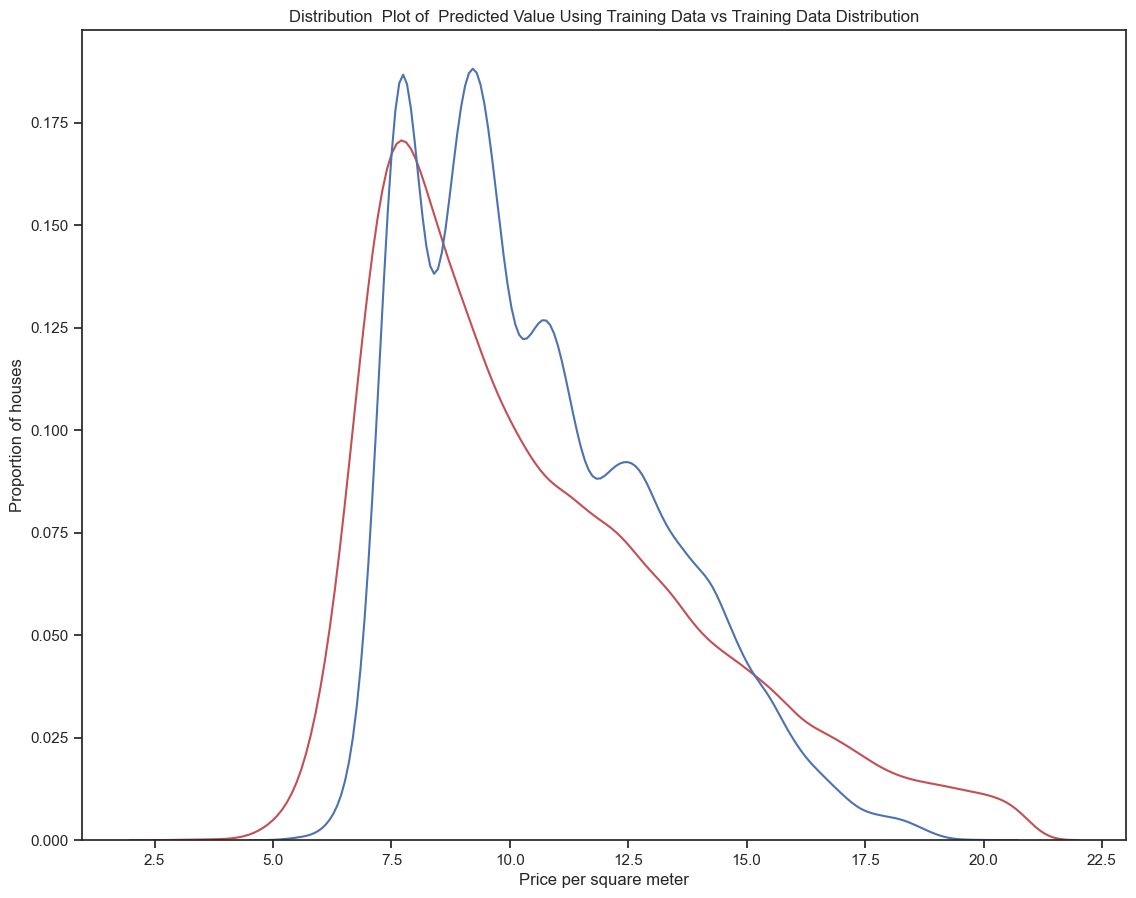

In [153]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, y_train_hat, "Actual Values (Train)", "Predicted Values (Train)", Title)

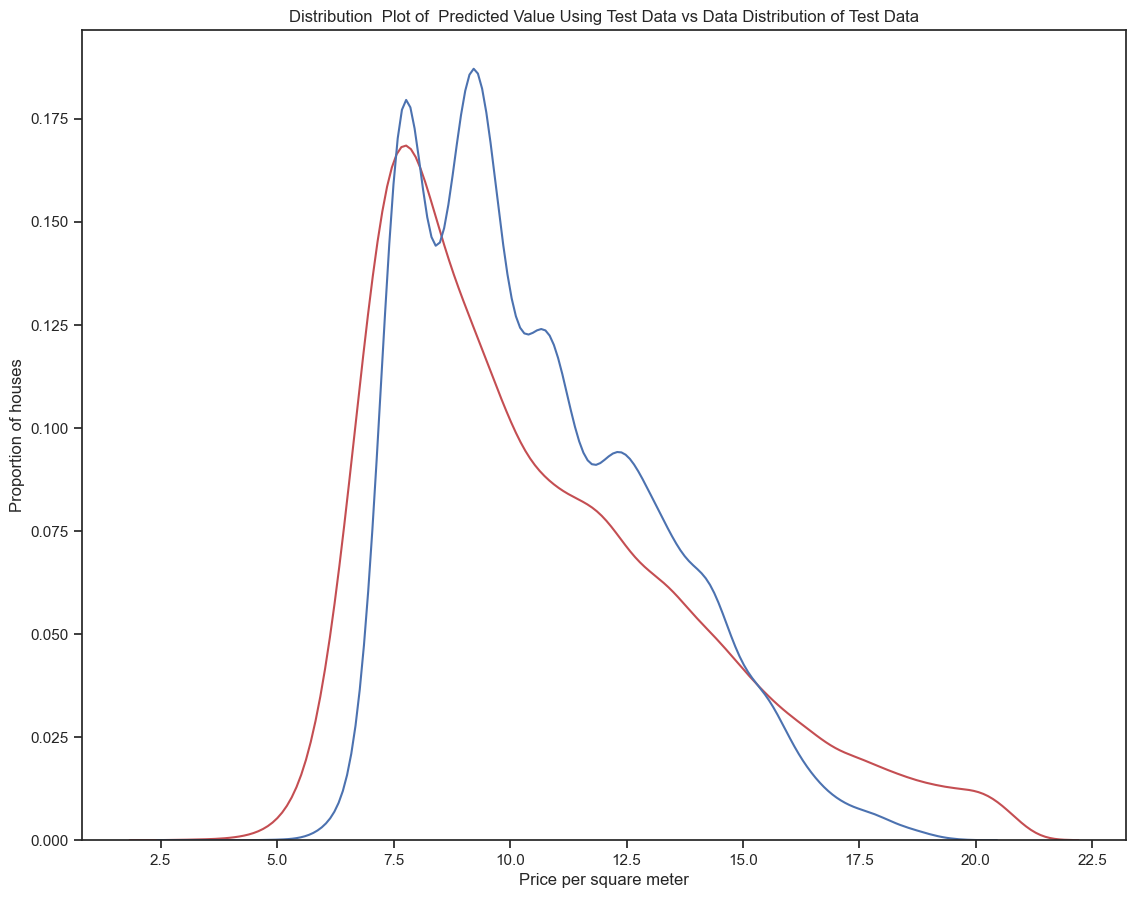

In [154]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,y_test_hat,"Actual Values (Test)","Predicted Values (Test)",Title)